In [ ]:
# Downloading the movielens datasets and Book-Crossing Dataset

# Movielens Dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
# Book-Crossing Dataset
!wget http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
!unzip BX-CSV-Dump.zip

--2022-10-15 07:50:43--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   720KB/s    in 1.3s    

2022-10-15 07:50:45 (720 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  
--2022-10-15 07:50:46--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to 

In [ ]:
# Importing reuired packages
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reading required files
ratings = pd.read_csv("ml-latest-small/ratings.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
book_rating_data = pd.read_csv("BX-Book-Ratings.csv", encoding='latin1', sep=';')

In [ ]:
# Snapshot of the loaded dataset
print(ratings.head())
print(movies.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X           

In [ ]:
# Function for creation of Index for both the Movielens and Book rating datasets
def user_item_index(col):
  user_item_ids = col.unique().tolist()
  user_item_idx = {x: i for i, x in enumerate(user_item_ids)}
  idx_user_item = {i: x for i, x in enumerate(user_item_ids)}
  return user_item_idx

In [ ]:
#Generating unique index for the user as well as the item

ratings["user"] = ratings["userId"].map(user_item_index(ratings["userId"]))
ratings["item"] = ratings["movieId"].map(user_item_index(ratings["movieId"]))


book_rating_data["user"] = book_rating_data["User-ID"].map(user_item_index(book_rating_data["User-ID"]))
book_rating_data["item"] = book_rating_data["ISBN"].map(user_item_index(book_rating_data["ISBN"]))
book_rating_data.rename(columns = {'Book-Rating':'rating'}, inplace=True)

In [ ]:
# Cnapshot of the newly created columns
print(ratings.head())
print(book_rating_data.head())

   userId  movieId  rating  timestamp  user  item
0       1        1     4.0  964982703     0     0
1       1        3     4.0  964981247     0     1
2       1        6     4.0  964982224     0     2
3       1       47     5.0  964983815     0     3
4       1       50     5.0  964982931     0     4
   User-ID        ISBN  rating  user  item
0   276725  034545104X       0     0     0
1   276726  0155061224       5     1     1
2   276727  0446520802       0     2     2
3   276729  052165615X       3     3     3
4   276729  0521795028       6     3     4


In [ ]:
# Preliminary view for the unique users and the items
num_users = len(ratings["userId"].unique().tolist())
num_items = len(ratings["movieId"].unique().tolist())

br_num_users = len(book_rating_data["User-ID"].unique().tolist())
br_num_items = len(book_rating_data["ISBN"].unique().tolist())


print(num_users)
print(num_items)
print(br_num_users)
print(br_num_items)


610
9724
105283
340556


In [ ]:
# Creation of Train and Val datasets for the purpose of modelling starts here
# Change the dataset name as per the interest - movielens dataset > ratings, book rating dataset > book_rating_data

rating = book_rating_data
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(804846, 2)
(804846,)
(344934, 2)
(344934,)


In [ ]:
print(y_val)
print(x_val)

[0.  0.5 0.7 ... 0.  1.  0. ]
[[ 95134 245658]
 [ 55817  73313]
 [ 64776 195957]
 ...
 [ 43533  30040]
 [ 45274  16101]
 [ 11893  68630]]


In [ ]:
# Model creation using Matrix Factorisation Methodology
class Recomm(keras.Model):
  def __init__(self, num_users, num_items, embedding_size, **kwargs):
    super(Recomm, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_size = embedding_size
    self.user_embed = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.item_embed = layers.Embedding(
        num_items,
        embedding_size,
        embeddings_initializer="uniform",
        embeddings_regularizer=keras.regularizers.l2(1e-6)
    )
    self.item_bias = layers.Embedding(num_items, 1)



  def call(self, inputs):
    user_vector = self.user_embed(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    item_vector = self.item_embed(inputs[:,1])
    item_bias = self.item_bias(inputs[:,1])
    #dot_user_item = tf.tensordot(user_vector, item_vector, 2)
    dot_user_item = layers.dot([user_vector, item_vector], axes=1)

    x = dot_user_item + user_bias + item_bias
    return tf.nn.sigmoid(x)

In [ ]:
# Fitting model for different Embedding Dimensions and storing the validation loss for further analysisin -'new'
Embedding_size = [8, 16, 32, 64] 


new = {'val_loss':[]}
for i in Embedding_size:
  model = Recomm(br_num_users, br_num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam())
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  new['val_loss'].append(history.history['val_loss'])


Epoch 1/5
12576/12576 [==============================] - 68s 5ms/step - loss: 0.5882 - val_loss: 0.5377
Epoch 2/5
12576/12576 [==============================] - 63s 5ms/step - loss: 0.5160 - val_loss: 0.5179
Epoch 3/5
12576/12576 [==============================] - 64s 5ms/step - loss: 0.4947 - val_loss: 0.5113
Epoch 4/5
12576/12576 [==============================] - 62s 5ms/step - loss: 0.4812 - val_loss: 0.5087
Epoch 5/5
12576/12576 [==============================] - 63s 5ms/step - loss: 0.4707 - val_loss: 0.5084
Epoch 1/5
12576/12576 [==============================] - 94s 7ms/step - loss: 0.5880 - val_loss: 0.5385
Epoch 2/5
12576/12576 [==============================] - 93s 7ms/step - loss: 0.5171 - val_loss: 0.5195
Epoch 3/5
12576/12576 [==============================] - 93s 7ms/step - loss: 0.4953 - val_loss: 0.5125
Epoch 4/5
12576/12576 [==============================] - 83s 7ms/step - loss: 0.4806 - val_loss: 0.5101
Epoch 5/5
12576/12576 [==============================] - 83s 7ms

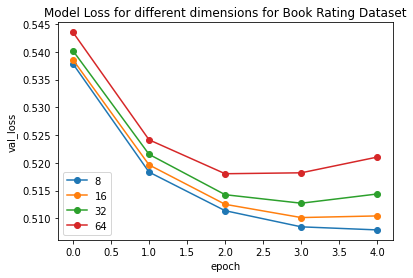

In [ ]:
# Code for plotting validation losses across epochs
for i, v in val_losses_data.iterrows():
  plt.plot(val_losses_data['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for Book Rating Dataset')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data['Dim'], loc='lower left')
plt.show()

## Movielens Dataset - This snippet consist of model training  for the Movie Lens data

In [ ]:
# Implementation specific to the movie lens dataset

rating = ratings
rating["rating"] = rating["rating"].values.astype(np.float32)

min_rating = min(rating["rating"])
max_rating = max(rating["rating"])

# Creation of train and validation dataset
data = rating.sample(frac=1, random_state=1)
x = data[["user","item"]].values
y = data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#y = data["rating"]


train_indices = int(0.7 * data.shape[0])

x_train, x_val, y_train, y_val = (x[:train_indices], x[train_indices:], y[:train_indices], y[train_indices:])

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(70585, 2)
(70585,)
(30251, 2)
(30251,)


In [ ]:
# Creation of training loop
Embedding_size = [8, 16, 32, 64] 


movielens = {'val_loss':[]}
for i in Embedding_size:
  model = Recomm(num_users, num_items, i)
  model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001))
  history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val)
  )

  movielens['val_loss'].append(history.history['val_loss'])


Epoch 1/5
1103/1103 [==============================] - 4s 3ms/step - loss: 0.6615 - val_loss: 0.6323
Epoch 2/5
1103/1103 [==============================] - 3s 3ms/step - loss: 0.6130 - val_loss: 0.6065
Epoch 3/5
1103/1103 [==============================] - 3s 3ms/step - loss: 0.5962 - val_loss: 0.6010
Epoch 4/5
1103/1103 [==============================] - 3s 3ms/step - loss: 0.5890 - val_loss: 0.5991
Epoch 5/5
1103/1103 [==============================] - 3s 3ms/step - loss: 0.5844 - val_loss: 0.5985
Epoch 1/5
1103/1103 [==============================] - 6s 4ms/step - loss: 0.6602 - val_loss: 0.6279
Epoch 2/5
1103/1103 [==============================] - 5s 4ms/step - loss: 0.6086 - val_loss: 0.6044
Epoch 3/5
1103/1103 [==============================] - 4s 4ms/step - loss: 0.5925 - val_loss: 0.6001
Epoch 4/5
1103/1103 [==============================] - 5s 4ms/step - loss: 0.5845 - val_loss: 0.5987
Epoch 5/5
1103/1103 [==============================] - 5s 4ms/step - loss: 0.5781 - val_los

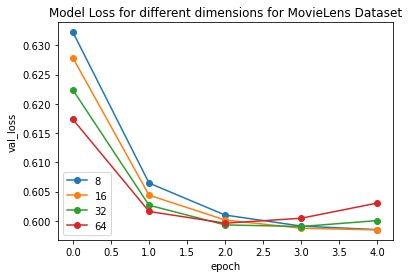

In [ ]:
# 'new_output' is a dataframe with stacked validation losses fro different Embedding Dimensions
# Plot of validation losses for Movie Lens dataset
val_losses_data_movielens = pd.DataFrame(movielens)
val_losses_data_movielens['Dim'] = Embedding_size
val_losses_data_movielens.set_index(['Dim'])


for i, v in val_losses_data_movielens.iterrows():
  plt.plot(val_losses_data_movielens['val_loss'][i], '-o')
plt.title('Model Loss for different dimensions for MovieLens Dataset')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(val_losses_data_movielens['Dim'], loc='lower left')
plt.show()